In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from Preprocessing import ImagePreprocessing
from Postprocessing import ImagePostprocessing
import numpy as np
import matplotlib.pyplot as plt
from PatchFeatureExtractor import PatchFeatureExtractor
pfe = PatchFeatureExtractor()
from scipy.ndimage import convolve


In [10]:
from ImageLoader import ImageLoader
import os

image_dir = "images/"
image_paths = [os.path.join(image_dir, "pictures", fname) for fname in os.listdir(os.path.join(image_dir, "pictures"))]
labels_paths = [
    os.path.join(image_dir, "manual", os.path.basename(p).replace(".JPG", ".tif").replace(".jpg", ".tif"))
    for p in image_paths
]
masks_paths = [
    os.path.join(image_dir, "mask", os.path.basename(p).replace(".JPG", "_mask.tif").replace(".jpg", "_mask.tif"))
    for p in image_paths
]

images_list = ImageLoader.load_images(image_paths)
labels_list = ImageLoader.load_images(labels_paths)
masks_list = ImageLoader.load_images(masks_paths)

images = np.stack(images_list)
labels = np.stack(labels_list)
masks = np.stack(masks_list)

In [9]:
num_positive_pixels = np.sum([np.sum(label == 255) for label in labels])
num_negative_pixels = np.sum([np.sum(label == 0) for label in labels])

all = labels.shape[0] * labels.shape[1] * labels.shape[2]

files_with_more_than_2_unique = [labels_paths[i] for i, label in enumerate(labels) if len(np.unique(label)) > 2]
print("Files with more than 2 unique values:", files_with_more_than_2_unique)

print(num_positive_pixels, num_negative_pixels, (num_positive_pixels + num_negative_pixels) == all)

Files with more than 2 unique values: []
26062032 317722416 True


In [ ]:
print(images.shape, labels.shape, masks.shape)

(45, 2336, 3504, 3) (45, 2336, 3504) (45, 2336, 3504, 3)


In [ ]:
def feature_csv_header(patch_shape):
    """
    Returns a list of CSV header names for all features extracted by extract_features:
    - color variance (per channel)
    - central moments (3 per channel + 3 for grayscale)
    - Hu moments (7 per channel + 7 for grayscale)
    """
    h, w, c = patch_shape
    header = ['img_path']

    # Color variance
    for ch in range(c):
        header.append(f'var_ch{ch+1}')

    # Central moments (per channel)
    for ch in range(c):
        for m in ['mu20', 'mu11', 'mu02']:
            header.append(f'central_{m}_ch{ch+1}')
    # Central moments (gray)
    for m in ['mu20', 'mu11', 'mu02']:
        header.append(f'central_{m}_gray')

    # Hu moments (per channel)
    for ch in range(c):
        for i in range(1, 8):
            header.append(f'hu{i}_ch{ch+1}')
    # Hu moments (gray)
    for i in range(1, 8):
        header.append(f'hu{i}_gray')

    header.append('label')
    return header

header = feature_csv_header((5,5,3))

In [ ]:
from scipy.ndimage import convolve
import csv

num_images = images.shape[0]
class_patches_per_img = 1000000 // (2 * num_images)
patch_size = 5

with open('data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    patches = []
    features = []
    patch_labels = []

    for img_idx, (image, label, mask) in enumerate(zip(images, labels, masks)):
        positive_idx = []
        negative_idx = []
        half_patch = patch_size // 2

        # Convert mask to single channel if needed
        if mask.ndim == 3 and mask.shape[2] > 1:
            mask_gray = (mask[..., 0] > 0).astype(np.uint8)
        else:
            mask_gray = (mask > 0).astype(np.uint8)

        kernel = np.ones((patch_size, patch_size), dtype=np.uint8)
        valid_mask = convolve(mask_gray, kernel, mode='constant', cval=0)
        valid_mask = valid_mask == (patch_size * patch_size)

        for y in range(half_patch, label.shape[0] - half_patch):
            for x in range(half_patch, label.shape[1] - half_patch):
                if valid_mask[y, x]:
                    if label[y, x] == 1:
                        positive_idx.append((y, x))
                    elif label[y, x] == 0:
                        negative_idx.append((y, x))
        np.random.shuffle(positive_idx)
        np.random.shuffle(negative_idx)

        num_pos = min(len(positive_idx), class_patches_per_img)
        num_neg = min(len(negative_idx), class_patches_per_img)

        selected_pos = positive_idx[:num_pos]
        selected_neg = negative_idx[:num_neg]

        for y, x in selected_pos:
            patch = image[y - half_patch:y + half_patch + 1, x - half_patch:x + half_patch + 1]
            patches.append(patch)
            feats = pfe.extract_features(patch)
            features.append(feats)
            patch_labels.append(1)
            row = [image_paths[img_idx]] + list(feats) + [1]
            writer.writerow(row)

        for y, x in selected_neg:
            patch = image[y - half_patch:y + half_patch + 1, x - half_patch:x + half_patch + 1]
            patches.append(patch)
            feats = pfe.extract_features(patch)
            features.append(feats)
            patch_labels.append(0)
            row = [image_paths[img_idx]] + list(feats) + [0]
            writer.writerow(row)

In [ ]:
print(len(patches), len(features))
print(len(features[0]))

500200 500200
43


In [ ]:
import pandas as pd
import numpy as np

# Convert features list to DataFrame
features_array = np.array(features)
features_df = pd.DataFrame(features_array, columns=header[1:-1])  # exclude 'img_path' and 'label'

# Compute correlation matrix
correlation_matrix = features_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                    var_ch1   var_ch2   var_ch3  central_mu20_ch1  \
var_ch1            1.000000  0.578661  0.535296          0.214043   
var_ch2            0.578661  1.000000  0.385634          0.181145   
var_ch3            0.535296  0.385634  1.000000         -0.010666   
central_mu20_ch1   0.214043  0.181145 -0.010666          1.000000   
central_mu11_ch1  -0.012012 -0.004530 -0.012830          0.001923   
central_mu02_ch1   0.211851  0.179029 -0.015946          0.999224   
central_mu20_ch2   0.209602  0.157594 -0.021791          0.801473   
central_mu11_ch2  -0.021651 -0.008327 -0.018825          0.002950   
central_mu02_ch2   0.207924  0.156874 -0.025323          0.801212   
central_mu20_ch3   0.074801  0.105672 -0.072690          0.638326   
central_mu11_ch3  -0.055139 -0.020532 -0.046298         -0.000313   
central_mu02_ch3   0.072096  0.103892 -0.077485          0.637971   
central_mu20_gray  0.166518  0.150950 -0.048209          0.819597   
central_mu11_gray -0.034588 -0.013

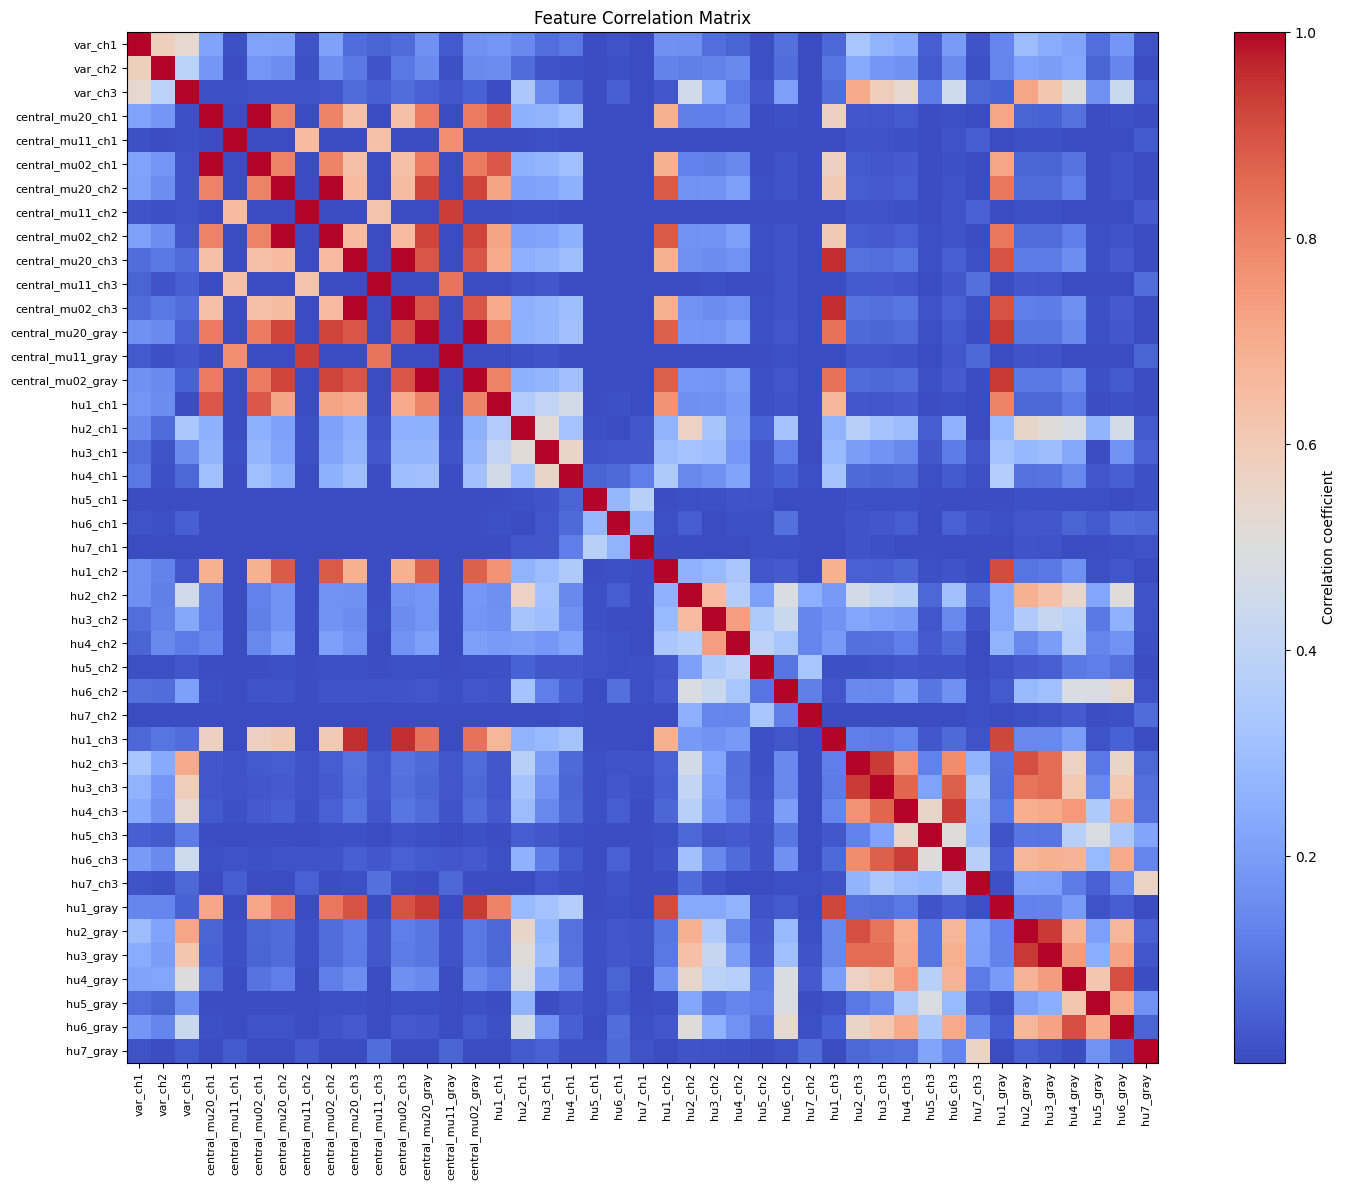

In [ ]:
import matplotlib.pyplot as plt

correlation_matrix_abs = np.abs(correlation_matrix)

plt.figure(figsize=(16, 12))
plt.imshow(correlation_matrix_abs, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(correlation_matrix_abs.columns)), correlation_matrix_abs.columns, rotation=90, fontsize=8)
plt.yticks(range(len(correlation_matrix_abs.index)), correlation_matrix_abs.index, fontsize=8)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

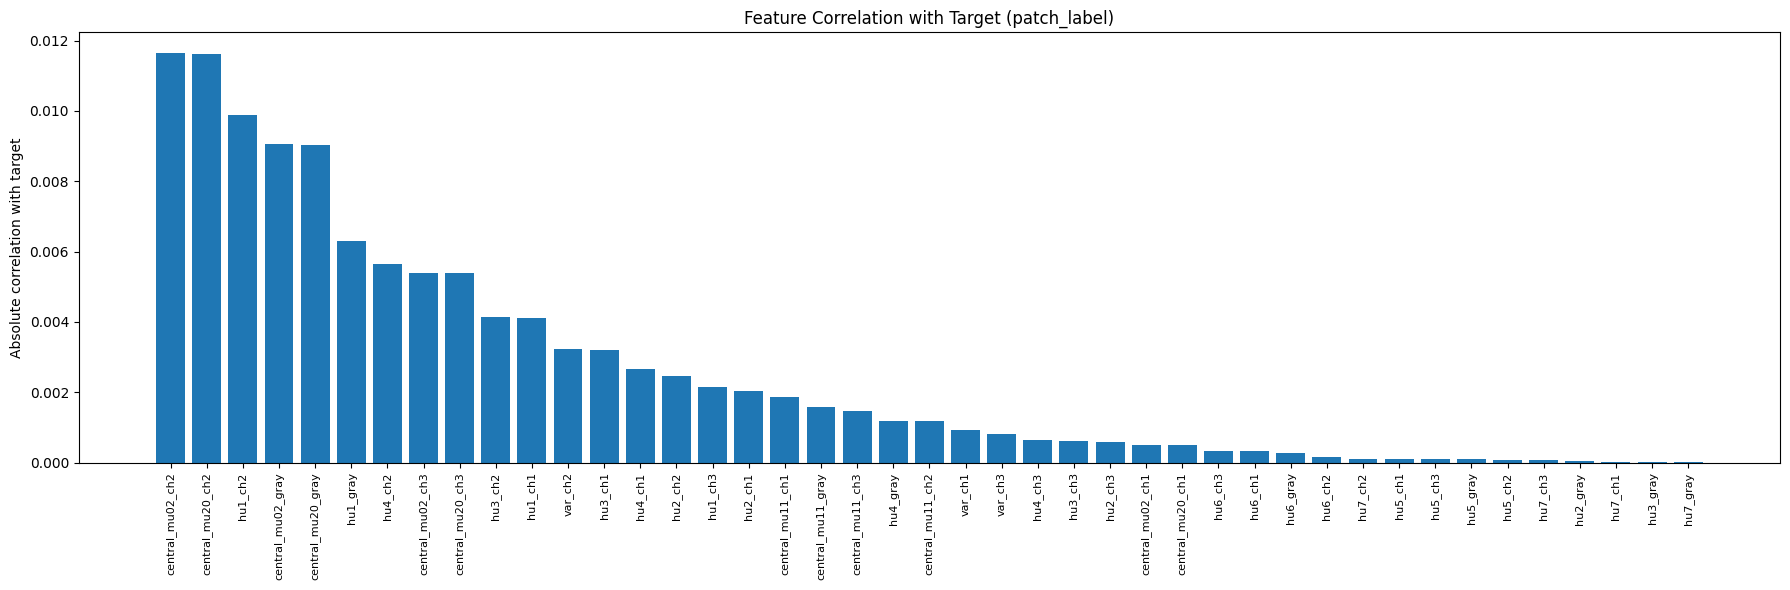

In [ ]:
# Compute correlation of each feature with the target (patch_labels)
feature_target_corr = features_df.apply(lambda col: np.corrcoef(col, patch_labels)[0, 1])

# Sort by absolute correlation
sorted_target_corr = feature_target_corr.abs().sort_values(ascending=False)

# Plot sorted histogram
plt.figure(figsize=(18, 6))
plt.bar(sorted_target_corr.index, sorted_target_corr.values)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Absolute correlation with target')
plt.title('Feature Correlation with Target (patch_label)')
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
data = pd.read_csv('data.csv')

In [2]:
from MLModel import MLModel

model = MLModel(model_type='las')

In [ ]:
from Dataset import ImageDataset
from sklearn.model_selection import train_test_split

# Select features (X) and target (Y)
X = data.iloc[:, 1:-1]  # all columns except first and last
Y = data.iloc[:, -1]    # last column

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = ImageDataset(X_train.values, Y_train.values)
test_dataset = ImageDataset(X_test.values, Y_test.values)

In [7]:
model.train(X_train, Y_train)

In [8]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Get model predictions for X_test
y_pred = model.predict(X_test)

# Evaluate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9996
Precision: 0.0000
Recall: 0.0000


c:\Users\AniaV3\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
(Y == 1).sum()
(Y == 0).sum()

499995